**DATASET : THE DATASET IS TAKEN FROM KAGGLE WHICH IS CONSISTING 433 IMAGES OF CAR'S NUMBER PLATE.**

#1. Detect and extract number plates from input

**opencv-python: This is the Python binding for OpenCV — an open-source computer vision library used for image and video processing**.

**pytesseract: A Python wrapper for the Tesseract OCR engine, allowing you to run OCR on images.**

**tesseract-ocr: The core OCR engine**.

**libtesseract-dev: Development files for integrating Tesseract into apps (used internally by pytesseract).**

In [ ]:
# Install required libraries
!pip install opencv-python pytesseract

# Install Tesseract OCR in Colab
!apt install tesseract-ocr -y
!apt install libtesseract-dev -y

# Import required libraries
import cv2
import pytesseract
import os
from google.colab.patches import cv2_imshow

# Set Tesseract path
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()

Saving Cars0.png to Cars0 (1).png


#2.Recognize and interpret alphanumeric characters on the plates.


In [ ]:
def detect_and_crop_plate(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(blur, 30, 200)

    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    for c in contours:
        approx = cv2.approxPolyDP(c, 0.018 * cv2.arcLength(c, True), True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            return image[y:y + h, x:x + w]
    return None

#3.Handle challenges like lighting and angles.

In [ ]:
def preprocess_and_recognize(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply dilation/erosion if needed
    text = pytesseract.image_to_string(thresh, config='--psm 8')
    return text.strip()


Processing: Cars0 (1).png
Detected Plate Text: KEG1CA2595


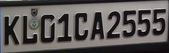

In [ ]:
# Run the full pipeline on all uploaded images
for filename in uploaded.keys():
    print(f"\nProcessing: {filename}")
    img = cv2.imread(filename)
    plate = detect_and_crop_plate(img)

    if plate is not None:
        text = preprocess_and_recognize(plate)
        print(f"Detected Plate Text: {text}")
        cv2_imshow(plate)
    else:
        print("Number plate not detected.")

#4.Evaluation metrics

In [ ]:
# Simple IoU for one box
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    return interArea / (boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0

# Simple character accuracy
def char_accuracy(pred, true):
    matches = sum(p == t for p, t in zip(pred, true))
    return matches / max(len(true),1)

# Simple word accuracy (exact match)
def word_accuracy(pred, true):
    return int(pred == true)

# Example usage:
pred_boxes = [(50,30,100,40)]   # predicted bounding boxes
true_boxes = [(48,28,102,42)]   # ground truth boxes

pred_texts = ["KEG1CA2595"]         # predicted plate texts
true_texts = ["KEG1CA2595"]         # ground truth texts

print("IoU:", iou(pred_boxes[0], true_boxes[0]))
print("Character Accuracy:", char_accuracy(pred_texts[0], true_texts[0]))
print("Word Accuracy:", word_accuracy(pred_texts[0], true_texts[0]))


IoU: 0.9337068160597572
Character Accuracy: 1.0
Word Accuracy: 1
